In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator
#import seaborn as sns
from sklearn.metrics import mean_squared_error

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras import backend
import os
from pandas import DataFrame
from numpy import concatenate
from tensorflow.keras import regularizers

import tensorflow as tf
print("Tensorflow:", tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, BatchNormalization, Activation, Dropout, LeakyReLU, PReLU
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import datetime
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

from math import sqrt
import math

Tensorflow: 2.0.0-alpha0


Using TensorFlow backend.


In [2]:
np.random.seed(1337)

In [3]:
#********Load data**************************

dataset = pd.read_csv('murdoch_system_incoming_traffic.csv', usecols = [2])
dataset

,2170
0,788
1,808
2,1710
3,7668
4,8863
5,1113
6,11704
7,2304
8,12899
9,22029


In [4]:
dataset.column=['traffic']

c:\users\31950627\kerast\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [5]:
#**************** Drop nan and zero values******************************

dataset = dataset.replace(0, np.nan)
dataset = dataset.dropna(how='all', axis=0)
dataset = dataset.replace(np.nan, 0)

In [6]:
dataset

,2170
0,788.0
1,808.0
2,1710.0
3,7668.0
4,8863.0
5,1113.0
6,11704.0
7,2304.0
8,12899.0
9,22029.0


In [7]:
#********Data normalization**************************

dataset= np.array(dataset)
dataset= dataset.astype('float32')


#np.isfinite(dataset).all()

# *****************split into train and test sets********************

train_size = int(len(dataset) * 0.90)
test_size = len(dataset) - train_size
data_train = dataset[0:train_size]
data_test = dataset[train_size:len(dataset)]
print('Data_train', data_train.shape, 'Data_test',data_test.shape)

# ********Normalize the data******************

scaler= MinMaxScaler (feature_range= (-1,1))
train_scaled = scaler.fit_transform(data_train)
test_scaled = scaler.transform(data_test)
print('Train_scaled',train_scaled.shape,' Test scaled', test_scaled.shape)

Data_train (1038861, 1) Data_test (115429, 1)
Train_scaled (1038861, 1)  Test scaled (115429, 1)


In [8]:
# ******************frame a sequence as a supervised learning problem*************

def prepare_seq2seq_data(dataset, look_back=1):

    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 3
train_X, train_y = prepare_seq2seq_data(train_scaled , look_back)
test_X, test_y = prepare_seq2seq_data(test_scaled , look_back)

print('train_X',train_X.shape, 'train_y',train_y.shape)
print('test_X', test_X.shape, 'test_y',test_y.shape)

# ********convert 1 D to 2D array****************************************

train_y = train_y.reshape((train_y.shape[0], 1))
test_y = test_y.reshape((test_y.shape[0], 1))
print('train_y',train_y.shape)


train_X (1038857, 3) train_y (1038857,)
test_X (115425, 3) test_y (115425,)
train_y (1038857, 1)


In [9]:
#******************* Batch generator****************************
def batch_generator(X, Y, batch_size):
    """
    Generator function for creating random batches of training-data.
    """
    while True:
        num_records = X.shape[0]
        timesteps = X.shape[1]
        num_batches = num_records // batch_size
        for idx in range(num_batches):
            x = X[idx*batch_size:(idx+1)*batch_size, :].reshape(batch_size, timesteps, 1)
            y = Y[idx*batch_size:(idx+1)*batch_size, :].reshape(batch_size, 1)
            yield (x, y)

In [10]:
#***********We then create the batch generator***********************
batch_size=64
generator = batch_generator(train_X, train_y, batch_size)
validation_data = batch_generator(test_X, test_y, batch_size)

x_batch, y_batch = next(generator)

print(x_batch.shape)
print(y_batch.shape)

(64, 3, 1)
(64, 1)


In [11]:
#**********RPE******************************
def rpe(y_true, y_pred):
    
    return backend.abs((y_pred - y_true)/y_true) * 100

In [12]:
#********************Build Model****************************

def build_model():
    
    model = tf.keras.models.Sequential()
    model.add(LSTM(256, input_shape=(look_back, 1),kernel_initializer='glorot_uniform',activation='relu'
                   ))
                    
    model.add(Dropout(0.1))

    model.add(Dense(1))
    model.summary()
    
    #optimizer = tf.keras.optimizers.Adam()
        
    optimizer = tf.keras.optimizers.Adam(lr=0.0001, clipnorm=1.0)
    model.compile(optimizer=optimizer,
                       loss='mean_squared_error', metrics=[rpe])
    
    #model.fit (train_X, train_y)
    
    return model


In [13]:
#*******Reshape from[samples, timesteps] into [samples, timesteps, features]*************

train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)
print('train_X',train_X.shape, 'train_y',train_y.shape)
print('test_X', test_X.shape, 'test_y',test_y.shape)


train_X (1038857, 3, 1) train_y (1038857, 1)
test_X (115425, 3, 1) test_y (115425, 1)


In [14]:
#*******************Train the model******************************

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
callbacks = [callback_early_stopping]

model =build_model()

history= model.fit_generator(generator=generator,
                    epochs=500,
                    steps_per_epoch=10, validation_data=validation_data, validation_steps=64, shuffle=False, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unified_lstm (UnifiedLSTM)   (None, 256)               264192    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
10/10 [==============================] - 3s 281ms/step - loss: 0.9576 - rpe: 97.8588 - val_loss: 0.9266 - val_rpe: 96.2947
Epoch 2/500
10/10 [==============================] - 0s 39ms/step - loss: 0.9040 - rpe: 95.1078 - val_loss: 0.8746 - val_rpe: 93.5691
Epoch 3/500
10/10 [==============================] - 0s 45ms/step - loss: 0.8534 - rpe: 92.3824 - val_loss: 0.8

In [15]:
# **************************Model Performance Error  metrics*************************************

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,rpe,val_loss,val_rpe,epoch
495,0.001301,2.886594,0.000019,0.363314,495
496,0.001039,2.550360,0.000022,0.311483,496
497,0.000992,2.526860,0.000016,0.154839,497
498,0.001117,2.640019,0.000037,0.322470,498
499,0.001076,2.668306,0.000010,0.119857,499


In [16]:

# *********************make predictions*************************************************************

trainPredict = model.predict(train_X)
testPredict = model.predict(test_X)

# *****************Relative Percentage Error before inverse*****************************************

def mean_relative_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

RPE = round (mean_relative_percentage_error (test_y, testPredict), 2)
print ('Relative Percentage Error before inverse:', RPE)


# *************************invert predictions**************************

trainPredict_inv = scaler.inverse_transform(trainPredict)
train_y_inv = scaler.inverse_transform(train_y)

testPredict_inv = scaler.inverse_transform(testPredict)
test_y_inv = scaler.inverse_transform(test_y)

# *****************Relative Percentage Error after inverse*****************************************

RPE = round (mean_relative_percentage_error (test_y_inv, testPredict_inv), 2)
print ('Relative Percentage Error after inverse:', RPE)

# ********************RMSE*************************

trainScore = math.sqrt(mean_squared_error(train_y_inv, trainPredict_inv))
print('Train Score RMSE: %.2f ' % trainScore)
testScore = math.sqrt(mean_squared_error(test_y_inv, testPredict_inv))
print('Test Score RMSE: %.2f' % testScore)

Relative Percentage Error before inverse: 0.13
Relative Percentage Error after inverse: 4082.14
Train Score RMSE: 613426.08 
Test Score RMSE: 290068.45


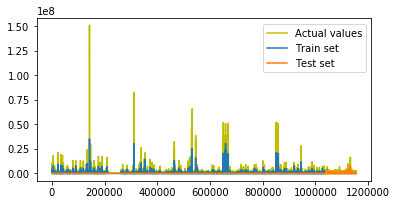

In [17]:
# ***********************shift train predictions for plotting*******************************

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = 0
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict_inv
    
# **********************shift test predictions for plotting*************************************

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = 0
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict_inv
    
# ********************Create the plot*************************************************************

plt.figure(figsize = (6, 3))
plt.plot(dataset, label= 'Actual values', color='y')
plt.plot(trainPredictPlot, label= 'Train set')
plt.plot(testPredictPlot, label= 'Test set')
plt.legend(bbox_to_anchor=(1, .99))
plt.show()


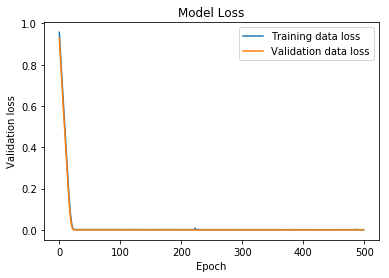

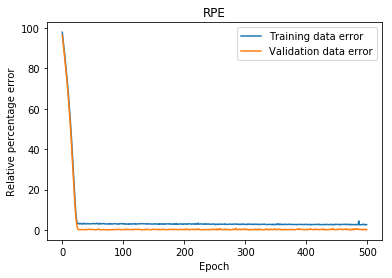

In [18]:
#***************************************Model validation loss*****************************************
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Validation loss')
plt.xlabel('Epoch')
plt.legend(['Training data loss', 'Validation data loss'], loc='upper right')
plt.show()

 #***************************************RPE*****************************************
plt.figure()
plt.plot(history.history['rpe'])
plt.plot(history.history['val_rpe'])
plt.title('RPE')
plt.ylabel('Relative percentage error')
plt.xlabel('Epoch')
plt.legend(['Training data error', 'Validation data error'], loc='upper right')
plt.show()

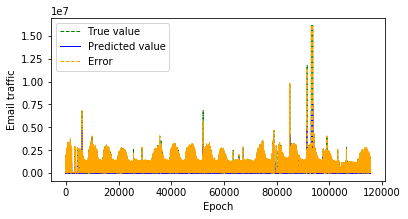

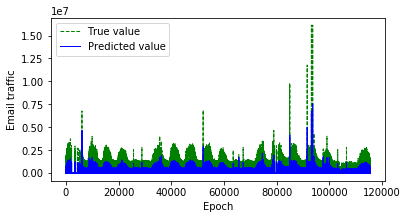

In [19]:
#********************* Actual value, Predicted value and Prediction Error ***************

plt.figure(figsize = (6, 3))
plt.xlabel("Epoch")
plt.ylabel("Email traffic")
plt.plot(test_y_inv[:,0], label="True value", linewidth=1,linestyle="--",color= 'green')
plt.plot(testPredict_inv[:,0], label="Predicted value", linewidth=1,color='blue')

error = abs(test_y_inv[:,0] - testPredict_inv[:,0])
plt.plot(error, label='Error',color= 'orange', linewidth=1, linestyle="--")
plt.legend()
plt.show()

#******************************* True value vs Prediction **********************/

plt.figure(figsize = (6, 3))
plt.xlabel("Epoch")
plt.ylabel("Email traffic")
plt.plot (test_y_inv[:,0], label="True value", linewidth=1,color= 'green', linestyle="--")
plt.plot(testPredict_inv[:,0], label="Predicted value", linewidth=1,color='blue')
plt.legend()
plt.show()

# RNN model

In [20]:
#********************Build Model****************************

def build_RNNmodel():
    
    model2 = tf.keras.models.Sequential()
    model2.add(SimpleRNN(256, input_shape=(look_back, 1),kernel_initializer='glorot_uniform',activation='relu'
                 ))
    model2.add(Dropout(0.1))

    model2.add(Dense(1))
    model2.summary()
    
    #optimizer = tf.keras.optimizers.Adam()
        
    optimizer = tf.keras.optimizers.Adam(lr=0.0001, clipnorm=1.0)
    model2.compile(optimizer=optimizer,
                       loss='mean_squared_error', metrics=[rpe])
    
    #model.fit (train_X, train_y)
    
    return model2

In [21]:
#*******************Train the model******************************

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
callbacks = [callback_early_stopping]

model2 =build_RNNmodel()

history2= model2.fit_generator(generator=generator,
                    epochs=500,
                    steps_per_epoch=10, validation_data=validation_data, validation_steps=64, shuffle=False, verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 256)               66048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 66,305
Trainable params: 66,305
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
10/10 [==============================] - 1s 133ms/step - loss: 0.8686 - rpe: 93.0245 - val_loss: 0.7137 - val_rpe: 84.5232
Epoch 2/500
10/10 [==============================] - 0s 18ms/step - loss: 0.6140 - rpe: 78.1741 - val_loss: 0.4872 - val_rpe: 69.8379
Epoch 3/500
10/10 [==============================] - 0s 19ms/step - loss: 0.3958 - rpe: 62.6180 - val_loss: 0.2

In [22]:
# *********************make predictions*************************************************************

trainPredict = model2.predict(train_X)
testPredict = model2.predict(test_X)

# *****************Relative Percentage Error before inverse*****************************************

def mean_relative_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

RPE = round (mean_relative_percentage_error (test_y, testPredict), 2)
print ('Relative Percentage Error before inverse:', RPE)


# *************************invert predictions**************************

trainPredict_inv = scaler.inverse_transform(trainPredict)
train_y_inv = scaler.inverse_transform(train_y)

testPredict_inv = scaler.inverse_transform(testPredict)
test_y_inv = scaler.inverse_transform(test_y)

# *****************Relative Percentage Error after inverse*****************************************

RPE = round (mean_relative_percentage_error (test_y_inv, testPredict_inv), 2)
print ('Relative Percentage Error after inverse:', RPE)

# ********************RMSE*************************

trainScore = math.sqrt(mean_squared_error(train_y_inv, trainPredict_inv))
print('Train Score RMSE: %.2f ' % trainScore)
testScore = math.sqrt(mean_squared_error(test_y_inv, testPredict_inv))
print('Test Score RMSE: %.2f' % testScore)

Relative Percentage Error before inverse: 0.23
Relative Percentage Error after inverse: 8646.06
Train Score RMSE: 625821.65 
Test Score RMSE: 307195.81
